# ROBOTICS - Tutorial 1 : Direct and inverse kinematics



## Introduction

We propose to study the __geometric__ and __kinematic__ modeling of a manipulator arm developed by the *Interactive Robotics Laboratory* of the *CEA List*. This robot, which kinematic chain is of serial type, has $6$ revolute joints ($j_i$ with $i=1,\ldots,6$).


<img src="Images/VueRobot.png" width="400">


The numerical values of the robot parameters, required for the completion of this tutorial, are specified in the following table.

$$
\begin{aligned}
& \text {Table. Numerical values of the robot parameters.}\\
&\begin{array}{cccc}
\hline
		\text{Parameters} &	\text{Numerical values} &	\text{Type of parameter} \\ 
		\hline
		d_3 & 0.7 m & \text{Geometric parameter} \\
		r_1 & 0.5 m & \text{Geometric parameter} \\
		r_4 & 0.2 m & \text{Geometric parameter} \\
        r_E & 0.1 m & \text{Geometric parameter} \\
\hline
\end{array}
\end{aligned}
$$

The use of *Python* is required to perform the tutorial. Please import the following required mathematical libraires to start the tutorial.

In [1]:
import numpy as np
import math as m
import functools as fu
from numpy.linalg import eig
import matplotlib.pyplot as plt
import random


In the following, you will progressively update a *Dictionnary* in Python containing the robot parameters, named __robotParameters__.

Please initialize it as follows: 
*robotParameters = { 'nJoints': 6, 'jointsType': ['R','R','R','R','R','R']}*

In [2]:
robotParameters = {'nJoints': 6, 'jointsType': ['R','R','R','R','R','R']}


You will also progressively build a *Class* containing some *attributes* related to the robot. To do so, you will be asked to program some of its *methods* in the tutorial. This class is named __RobotModel__ and is defined in the file *ClassRobotModel*.

Please initialize it as follows. You will see printing the resulting *attributes* of the *Class* __RobotModel__.

In [3]:
from ClassRobotModel import RobotModel
RobotTutorials = RobotModel( **robotParameters )


Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]


## Direct geometric model

__Q1.__ Fill in the following figure giving the frames attached to the successive links of the robot according to the *Modified Denavit-Hartenberg (MDH)* parameters defining the spatial arrangement of the robot structure (axis names and geometric distances should be reported on the completed figure).

<img src="Images/ParametresDH.png" width="600">

In [4]:
#from IPython.display import Image
#Image(filename='Images/ParametresDH_solution.png', width=600)


__Q2.__ To fill the following table with the geometric parameters of the robot:

$$
\begin{array}{ccccc}
		\hline
		\hline
		 i  & \alpha_i & d_i & \theta_i & r_i \\
		\hline
		\hline
		1  & ? & ? & ? & ? \\
		\hline
		2  & ? & ? & ? & ? \\
		\hline
		3  & ? & ? & ? & ? \\
		\hline
		4  & ? & ? & ? & ? \\
		\hline
		5  & ? & ? & ? & ? \\
		\hline
		6  & ? & ? & ? & ? \\
		\hline
		\hline
\end{array}
$$

please complete the file named *DHM_parameters.txt* in the current repository.

Then, update the dictionnary __robotParameters__ with the DHM parameters as follows: 

*robotParameters['fileDHM'] = "DHM_parameters.txt"*

*RobotTutorials = ClassRobotModel.RobotModel( **robotParameters )*

Look at the resulting *attribute* named *"self.tableDHM"*

In [5]:
robotParameters['fileDHM'] = "DHM_parameters.txt"
RobotTutorials = RobotModel( **robotParameters )


Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]


__Q3-a.__ Write a generic function $TransformMatElem(\alpha_i, d_i, \theta_i, r_i)$ which output argument is the homogeneous transform matrix *g* between two successive frames.

In [6]:
@staticmethod
def TransformMatElem( alpha_i, d_i, theta_i, r_i ):
    """ 
    Computation of the homogeneous transform matrix between two successive frames R_(i-1) and R_i
    
    Input: 
        - Four scalar parameters given by the Modified Denavit-Hartenberg (MDH) convention
    
    Output: 
        - Homogeneous transform matrix g_(i-1,i) as a "np.array"
    """
        
    ca, sa = np.cos( alpha_i ), np.sin( alpha_i )
    ct, st = np.cos( theta_i ), np.sin( theta_i )
    
    g_i = np.array( [[ct,      -st,     0,   d_i      ],
                     [ca * st, ca * ct, -sa, -r_i * sa],
                     [sa * st, sa * ct, ca,  r_i * ca ],
                     [0,       0,       0,   1        ]] )
    
    return g_i

RobotModel.TransformMatElem = TransformMatElem


In [7]:
def approx( u ):
    """
    Displays approximate values
    """
    return np.round( u, 3 )

__Q3-b.__Write a function $ComputeDGM(\text{self}, q)$ which computes the direct geometric model of any robot with series open kinematic chain, taking as input arguments the current configuration.

In [8]:
def ComputeDGM( self, q_cur ):
    """
    Computation of the Direct Geometric Model (DGM) of the robot given by its MDH parameters for the joint configuration q_cur
    
    Inputs: 
        - List of robot's geometric parameters "self.tableDHM" given by the Modified Denavit-Hartenberg (MDH) convention
        - Number of joints of the robot "self.numberJoints"
        - List of type of joints of the robot: "self.sigma"
        - Current joint configuration "q_cur"
    
    Outputs:
        - List of the successive homogeneous transform matrices: "self.list_g_i_1_i = [g_01, ..., g_N_1_N]"
        - List of the successive resulting homogeneous transform matrices: "self.list_g_0i = [g_01, g_02, ..., g_ON]"
    """
    
    self.list_g_i_1_i, self.list_g_0i = [], []
    
    for i in range( self.numberJoints ):
        alpha_i, d_i, theta_i, r_i = self.tableDHM[i][1:5]
        self.list_g_i_1_i.append( self.TransformMatElem( alpha_i, d_i, theta_i + q_cur[i], r_i ) )
        if ( i == 0 ):
            self.list_g_0i.append( self.list_g_i_1_i[0] )
        else:
            self.list_g_0i.append( self.list_g_0i[i - 1] @ self.list_g_i_1_i[i] ) # by recursion
    
    return self.list_g_i_1_i, self.list_g_0i

RobotModel.ComputeDGM = ComputeDGM

__Q3-c.__ We consider an end-effector mounted at the end of the robot arm. The frame $\mathcal{R}_E$ attached to the end-effector of the robot is defined by a translation of the frame  $\mathcal{R}_6$ by a distance $r_E$ along the $z_6$ axis.

Specify the four DHM parameters for the tool frame description in the field below.


In [9]:
robotParameters['toolFrameDHM'] = [0, 0, 0, 0.1]
RobotTutorials = RobotModel( **robotParameters )


Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]
Attribute (list - float): self.toolDHM =  [0, 0, 0, 0.1]


Using the results of previous questions, write a function $ComputeToolPose(\text{self})$  that computes the homogeneous transform matrix $\overline{g}_{0E}$. This matrix gives the position and the orientation of the frame $\mathcal{R}_E$ attached to the end-effector of the robot, expressed in the base frame $\mathcal{R}_0$.

In [10]:
def ComputeToolPose( self ):
    """ 
    Computation of the homogeneous transform matrix g0E which gives the position and the orientation of the frame R_E attached to the end-effector of the robot, expressed in the base frame R_0 evaluated at the joint configuration q_cur
    
    Inputs: 
        - List of the successive homogeneous transform matrices "self.list_g_0i"
        - Number of joints of the robot "self.numberJoints"
        - List of the geometric parameters of the tool "self.toolDHM" given by the Modified Denavit-Hartenberg (MDH) convention
    
    Output: 
        - Homogeneous transform matrix "self.g_0E"
    """
    
    alpha_E, d_E, theta_E, r_E = self.toolDHM
    self.g_0E = self.list_g_0i[self.numberJoints - 1] @ self.TransformMatElem( alpha_E, d_E, theta_E, r_E )
    return self.g_0E

RobotModel.ComputeToolPose = ComputeToolPose


In the following, we consider two joint configurations $q=\left[q_1, \ldots, q_6\right]^t$ of the robot: $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$ and $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$.

Indicate what are the homogeneous transform matrices $\overline{g}_{0E}$ evaluated in these two confugrations.

In [11]:
qi = np.pi/2 * np.array( [-1, 0,   -1, -1, -1, -1] )
qf = np.pi/2 * np.array( [0,  1/2, 0,   1,  1,  0] )

# since ComputeToolPose has no argument, we need to run ComputeDGM to take changes to q into account
RobotTutorials.ComputeDGM( qi )
RobotTutorials.ComputeToolPose()
print( approx( RobotTutorials.g_0E ) )

print( "" )

RobotTutorials.ComputeDGM( qf )
RobotTutorials.ComputeToolPose()
print( approx( RobotTutorials.g_0E ) )


[[-0.  -0.  -1.  -0.1]
 [ 1.  -0.  -0.  -0.7]
 [-0.  -1.   0.   0.3]
 [ 0.   0.   0.   1. ]]

[[-0.707  0.707  0.     0.636]
 [-0.    -0.    -1.    -0.1  ]
 [-0.707 -0.707  0.     1.136]
 [ 0.     0.     0.     1.   ]]


__Q4.__ What are the values of positions $P_x, P_y, P_z$ and the parameters related to the orientation $R_{n,q}$ ($n$ being the direction vector and $q \in \left[0,\pi\right]$ the rotation angle such that $R_{n,q}=R_{0E}$) of the end-effector frame for the two joint configurations $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$ and $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$ ($q=\left[q_1, \ldots, q_6\right]^t$)?
To do so, write a function $DescribeToolFrame(\text{self})$ that computes the position vector and the parameters related to the orientation of the end-effector frame for the current configuration.

In [12]:
def DescribeToolFrame( self ):
        """ 
        Computation of the position vector and the parameters related to the orientation R_n,q of the end-effector frame for the configuration q as specified in the constructor function 
                  
        Input: 
           - Direct Geometric Model (DGM) of the robot including its end-effector through "self.g_0E"
         
        Outputs: 
           - Values of positions P=[Px, Py, Pz]' (in m) of the origin of frame R_E w.r.t. R_0 given in R_0: "self.P"
           - Orientation parameters R_n,q, as follows:
                   - "self.n": being the direction vector
                   - "self.q" in [0,pi] the rotation angle in rad such that R_n,q = R_0E
        """
        
        self.P = self.g_0E[0:3, 3]
        
        r11, r12, r13 = self.g_0E[0,0], self.g_0E[0,1], self.g_0E[0,2]
        r21, r22, r23 = self.g_0E[1,0], self.g_0E[1,1], self.g_0E[1,2]
        r31, r32, r33 = self.g_0E[2,0], self.g_0E[2,1], self.g_0E[2,2]
        
        y = 1/2 * np.sqrt( ( r32 - r23 )**2 + ( r13 - r31 )**2 + ( r21 - r12 )**2 )
        x = 1/2 * ( r11 + r22 + r33 - 1 )
        
        self.q = m.atan2( y, x )
        self.n = np.array( [r32 - r23, r13 - r31, r21 - r12] / ( 2 * np.sin( self.q ) ) )
        
        return self.P, ( self.n, self.q )

RobotModel.DescribeToolFrame = DescribeToolFrame


In [13]:
# same as before, we need to make sure that g_0E is up to date
RobotTutorials.ComputeDGM( qi )
RobotTutorials.ComputeToolPose()
RobotTutorials.DescribeToolFrame()

print( approx( RobotTutorials.P ) )
print( approx( RobotTutorials.n ) )
print( approx( RobotTutorials.q ) )

print( "" )

RobotTutorials.ComputeDGM( qf )
RobotTutorials.ComputeToolPose()
RobotTutorials.DescribeToolFrame()

print( approx( RobotTutorials.P ) )
print( approx( RobotTutorials.n ) )
print( approx( RobotTutorials.q ) )


[-0.1 -0.7  0.3]
[-0.577 -0.577  0.577]
2.094

[ 0.636 -0.1    1.136]
[ 0.281  0.679 -0.679]
2.594


## Direct kinematic model

__Q5.__ Write a function $ComputeJac\left(self, q\right)$ which output is the Jacobian matrix ${}^0J(q)$ (computed by the method of velocities composition).

Reminder: the Jacobian matrix relates the velocities in the task coordinates of the end-effector frame in $\mathcal{R}_0$, for a given joint configuration $q$, to the joint velocities:
\begin{align*}
{}^0\mathcal{V}_{0,E}&= \begin{bmatrix}^0V_{0,E}\left(O_E\right) \\ ^0\omega_{0,E} \end{bmatrix} = \begin{bmatrix} {}^0J_v \left(q\right)  \\ {}^0J_{\omega} \left(q\right)\end{bmatrix} \dot{q} = {}^0J\left(q\right) \dot{q}
\end{align*}

In [14]:
 def ComputeJac( self, q_cur ):
        """ 
        Computation of the Jacobian matrix mapping the joint velocities to the velocities of the end-effector for a joint configuration "q_cur"
                
        Inputs: 
           - List defining the types of joints : "self.jointsType" 
           - Number of joints of the robot: "self.numberJoints"
           - Current configuration "q_cur"
         
        Output: 
           - Jacobian matrix 0_J in R_0: "self.oJ" as np.array
        """
        
        # we can finally specify the current value of q, so we can update attributes here
        self.ComputeDGM( q_cur )
        self.ComputeToolPose()
        self.DescribeToolFrame() # technically not needed, but it's more coherent to update everything
        
        self.oJ = []
        for i in range( self.numberJoints ):            
            R = self.list_g_0i[i][0:3, 0:3]
            Z = np.array( [0, 0, 1] )
            giN = np.linalg.inv( self.list_g_0i[i] ) @ self.g_0E
            p = giN[0:3, 3]
            
            if ( self.jointsType[i] == 'P' ):
                    J = np.concatenate( ( R @ Z, np.array( [0, 0, 0] ) ) )
            elif ( self.jointsType[i] == 'R' ):
                    J = np.concatenate( ( R @ np.cross( Z, p ), R @ Z ) )
            
            self.oJ.append( J.tolist() )
        
        self.oJ = np.array( self.oJ ).T

        return self.oJ
        
RobotModel.ComputeJac = ComputeJac


What are the values of the twists at $O_E$ evaluated with $q=q_i$ and $q=q_f$ with the joint velocities $\dot q = \left[0.5, 1.0, -0.5, 0.5, 1.0, -0.5\right]^t$?

In [15]:
qp = np.array( [0.5, 1., -0.5, 0.5, 1., -0.5] )

RobotTutorials.ComputeJac( qi )
print( approx( RobotTutorials.oJ ) )
print( approx( RobotTutorials.oJ @ qp ) )

print("")

RobotTutorials.ComputeJac( qf )
print( approx( RobotTutorials.oJ ) )
print( approx( RobotTutorials.oJ @ qp ) )


[[ 0.7  0.   0.   0.  -0.   0. ]
 [-0.1 -0.2 -0.2  0.1  0.   0. ]
 [ 0.   0.7  0.  -0.  -0.1  0. ]
 [ 0.  -1.  -1.  -0.  -0.  -1. ]
 [ 0.  -0.  -0.  -0.  -1.  -0. ]
 [ 1.   0.   0.  -1.  -0.   0. ]]
[ 0.35 -0.1   0.6   0.   -1.    0.  ]

[[ 0.1   -0.636 -0.141  0.071 -0.071  0.   ]
 [ 0.636  0.     0.    -0.     0.    -0.   ]
 [ 0.     0.636  0.141 -0.071 -0.071 -0.   ]
 [ 0.     0.     0.     0.707  0.707  0.   ]
 [ 0.    -1.    -1.    -0.    -0.    -1.   ]
 [ 1.     0.     0.     0.707 -0.707  0.   ]]
[-0.551  0.318  0.46   1.061 -0.     0.146]


__Q6.__ In the rest of the study, we restrict the analysis of operational end-effector velocities to translational velocities via ${}^0J_v \left(q\right)$.

Qualify the transmission of velocities between the joint and task spaces for the corresponding $q_i$ and $q_f$ configurations: what is the preferred direction to transmit velocity in the task space when the manipulator configuration is $q_i$? Same question for $q_f$? What are the corresponding velocity manipulabilities? 
To help, you can program a function $QualifyVelocityTransmission(self)$ that analyses the property of the Jacobian matrix. Explain your results.

In [16]:
def QualifyVelocityTransmission( self ):
    """ 
    Qualifying the transmission of velocities
              
    Input:
       - Jacobian matrix "self.oJ" to be analysed
     
    Outputs: 
       - To be defined...
    """
    epsilon = 1e-6 # prevents approximation errors in SVD
    
    u, s, _ = np.linalg.svd( self.oJ[0:3, :] ) # we only consider linear velocities
    
    self.preferred_direction = u[:, np.argmax( s )]
    
    self.velocity_manipulability = 1
    for i in range( len( s ) ):
        if ( abs( s[i] > epsilon ) ):
            self.velocity_manipulability = s[i] * self.velocity_manipulability
    
    return self.preferred_direction, self.velocity_manipulability

RobotModel.QualifyVelocityTransmission = QualifyVelocityTransmission


In [17]:
RobotTutorials.ComputeJac( qi )
RobotTutorials.QualifyVelocityTransmission()
print( approx( RobotTutorials.preferred_direction ) )
print( approx( RobotTutorials.velocity_manipulability ) )

print("")

RobotTutorials.ComputeJac( qf )
RobotTutorials.QualifyVelocityTransmission()
print( approx( RobotTutorials.preferred_direction ) )
print( approx( RobotTutorials.velocity_manipulability ) )


[ 0.366 -0.326  0.872]
0.112

[-0.711 -0.097  0.696]
0.059


## Inverse geometric model

__Q7.__ In this study, the resolution of the inverse geometric model is considered numerically by exploiting the inverse differential model. Moreover, the study is restricted to the position only of the robot's end-effector frame in the task space (no constraint on the orientation of the end-effector frame).

Using an iterative procedure exploiting the pseudo-inverse of the Jacobian matrix, program a function $ComputeIGM(\text{self}, X_d, q_0, k_{max}, \epsilon_x)$ having as input arguments the desired task position $X_d$ and the initial condition $q_0$. Both the maximum number of iterations $k_{max}$ of the algorithm and the norm of the tolerated Cartesian error $|X_d - DGM(q_{k})|<\epsilon_x$, define the stopping criteria of the algorithm.

In [18]:
def ComputeIGM( self, X_d, q_0, k_max, eps_x ):    
        """ 
        Computation of the Inverse Geometric Model (IGM) mapping the Cartesian pose to the joint vector "q"
                
        Inputs: 
           - Desired Cartesian vector "X_d" as a np.array to be reached by the robot 
           - Initial condition "q_0" as a np.array
           - Number "k_max" of maximal iteration in the recursive algorithm 
           - Norm of the tolerated Cartesian error "eps_x"
         
        Outputs: 
           - List "self.list_q_IGM" of the joint vectors computed at each iteration of the recursive algorithm 
           - Returned "self.list_q_IGM[-1]" of the final found joint vector, solution of the IGM
           
        """
        
        k = 0
        q = q_0
        self.ComputeJac( q )
        self.list_q_IGM = [q]
        
        while ( np.linalg.norm( X_d - self.P ) > eps_x and k < k_max ):
            k = k + 1
            q = self.list_q_IGM[-1]
            self.ComputeJac( q )
            self.list_q_IGM.append( q + np.linalg.pinv( self.oJ )[:, 0:3] @ ( X_d - self.P ) )
        
        return self.list_q_IGM, self.list_q_IGM[-1]

RobotModel.ComputeIGM = ComputeIGM


Compute $q^{\ast}$ when the function is called with the following arguments:

a) $X_d=X_{d_i}=\left(-0.1, -0.7, 0.3\right)^t$, $q_0=\left[ -1.57, 0.00 , -1.47, -1.47, -1.47 , -1.47 \right.$ $\left., -1.47 \right]$, $k_{max}=100$, $\epsilon_x=1$mm?

b) $X_d=X_{d_f}=\left(0.64 , -0.10, 1.14\right)^t$, $q_0=\left[ 0 , 0.80 , 0.00 , 1.00 , 2.00 , 0.00 \right]$, $k_{max}=100$, $\epsilon_x=1$mm?

Check the accuracy of the results using the function calculated in __Q3.__

In [19]:
k_max = 100
eps_x = 1e-3

X_d_i = np.array( [-0.1, -0.7, 0.3] )
q_0 = np.array( [-1.57, 0.0, -1.47, -1.47, -1.47, -1.47] )

_, q_star = RobotTutorials.ComputeIGM( X_d_i, q_0, k_max, eps_x )
print( approx( q_star ) )
print( approx( RobotTutorials.P ) )
print( np.linalg.norm( X_d_i - RobotTutorials.P ) )

print( "" )

X_d_f = np.array( [0.64, -0.1, 1.14] )
q_0 = np.array( [0.0, 0.8, 0.0, 1.0, 2.0, 0.0] )

_, q_star = RobotTutorials.ComputeIGM( X_d_f, q_0, k_max, eps_x )
print( approx( q_star ) )
print( approx( RobotTutorials.P ) )
print( np.linalg.norm( X_d_f - RobotTutorials.P ) )


[-1.572  0.015 -1.541 -1.478 -1.464 -1.414]
[-0.1 -0.7  0.3]
0.00031935922526185384

[ -6.407 -18.324 -68.075 -31.883 -31.884 301.935]
[ 0.64 -0.1   1.14]
8.464006962579012e-06


## Inverse kinematic model

In this question, the trajectory of the end-effector to be followed in the task space must allow the desired final position $X_{d_f}$ to be reached by following a straight line in the task space starting at the initial position $X_{d_i}$. This rectilinear motion is carried out at a constant speed $V=1m.s^{-1}$ and is sampled at a period $T_e=1$ms. The position of the end effector at the time instant $kT_e$ is noted $X_{d_k}$. The initial configuration of the robot is given by $q_i$ (found in question __Q4.__).

__Q8.__ Using the inverse differential kinematic model, write a function entitled $ComputeIKM( \text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i)$ realizing the coordinate transform to provide the series of setpoint values $q_{d_k}$ corresponding to the $X_{d_k}$ to the joint drivers. To do this, after having programmed the time law corresponding to the required motion, you can use the function developed in question __Q7__ capable of calculating the iterative MGI from the pseudo-inverse of the Jacobian matrix.

In [20]:
def ComputeIKM( self, X_d_i, X_d_f, V, Te, q_i, k_max, eps_x ):    
        """ 
        Computation of the Inverse differential Kinematic Model (IKM) making the coordinate transform to provide the series of setpoint values qdk corresponding to the Xdk to the joint drivers
        
        Inputs: 
           - Trajectory of the end effector to be followed in the task space between:
               - the initial position "X_d_i"
               - the desired final position "X_d_f" to be reached.
           - Rectilinear motion carried out :
               - at a constant speed "V"
               - sampled at a period "Te"
           - Initial configuration of the robot "q_i"
           - Number "k_max" of maximal iteration in the recursive algorithm (to be used with "self.ComputeIGM")
           - Norm of the tolerated Cartesian error "eps_x" (to be used with "self.ComputeIGM")
           
        Outputs: 
           - List "self.discreteTime" that defines the the sampled temporal series for each time step
           - List "self.list_X_d_k" of the intermediate Cartesian poses to be reached by the robot
           - List "self.list_q_dk" of the joint vectors computed at each iteration k of the recursive algorithm (series of setpoint values qdk corresponding to the Xdk to the joint drivers)
        """
        
        norm = np.linalg.norm( X_d_f - X_d_i )
        n_steps = (int)( norm / ( V * Te ) )
        
        self.discreteTime = [0]
        
        X_d = X_d_i
        self.list_X_d_k = [X_d]
        
        _, q_star = self.ComputeIGM( X_d_i, q_i, k_max, eps_x )
        self.list_q_dk = [q_star]
        
        percent = 0
        for i in range( n_steps ):
            if ( 100 * i / n_steps > percent + 5 ):
                percent = percent + 5
                print( str( percent ) + "%" )
                
            self.discreteTime.append( i * Te )
            
            X_d = self.list_X_d_k[-1] + ( X_d_f - X_d_i ) / norm * V * Te
            self.list_X_d_k.append( X_d )
            
            _, q_star = self.ComputeIGM( X_d, self.list_q_dk[-1], k_max, eps_x )
            self.list_q_dk.append( q_star )
        
        self.list_X_d_k = np.array( self.list_X_d_k )
        self.list_q_dk = np.array( self.list_q_dk )
        
        return self.discreteTime, self.list_X_d_k, self.list_q_dk

RobotModel.ComputeIKM = ComputeIKM


Check that the successively reached positions of the end-effector is following the desired trajectory. To do so, you can plot the error between the sequence of positions reached by the end device and the position set points at each time step.

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
[ 0.64 -0.1   1.14]
0.00011810475952698976


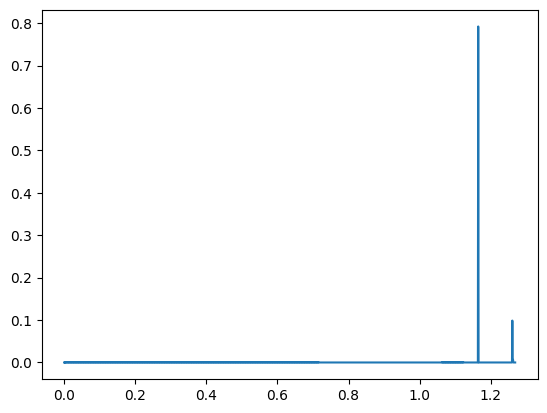

In [21]:
k_max = 100
eps_x = 1e-3

V = 1.0
Te = 1e-3

RobotTutorials.ComputeIKM( X_d_i, X_d_f, V, Te, qi, k_max, eps_x )

X_reached = []
for i in range( len( RobotTutorials.list_X_d_k ) ):
    RobotTutorials.ComputeDGM( RobotTutorials.list_q_dk[i] )
    RobotTutorials.ComputeToolPose()
    RobotTutorials.DescribeToolFrame()
    X_reached.append( RobotTutorials.P )

norms = [np.linalg.norm( X_reached[i] - RobotTutorials.list_X_d_k[i] )
         for i in range( len( RobotTutorials.list_X_d_k ) ) ]

plt.plot( RobotTutorials.discreteTime, norms )

print( approx( X_reached[-1] ) )
print( np.linalg.norm( X_reached[-1] - X_d_f ) )


__Q9.__ Plot the temporal evolution of the joint variables $q_1$ to $q_6$ calculated in the previous question. For each joint variable, graphically overlay the allowable extreme values corresponding to the joint limits:
\begin{align*}
q_{min} = \left[\begin{array}{c}{ -\pi , -\frac{\pi}{2} , -\pi , -\pi , -\frac{\pi}{2}, -\pi }\end{array}\right] 
\end{align*}
and
\begin{align*}
q_{max} = \left[\begin{array}{c}{ 0 , \frac{\pi}{2} , 0  ,\frac{\pi}{2}, \frac{\pi}{2} , \frac{\pi}{2} }\end{array}\right] 
\end{align*}

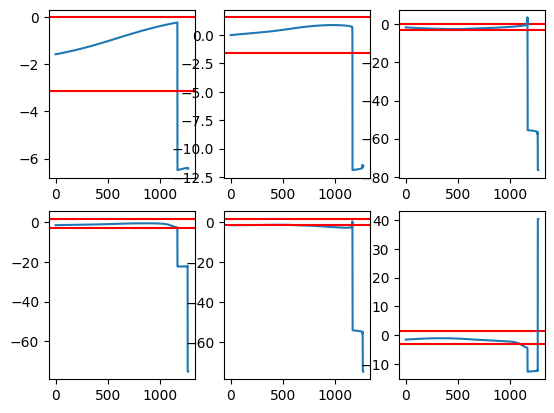

In [22]:
q_min = -np.pi * np.array( [1.0, 0.5, 1.0, 1.0, 0.5, 1.0] )
q_max = np.pi/2 * np.array( [0.0, 1.0, 0.0, 1.0, 1.0, 1.0] )

fig, axs = plt.subplots(2, 3)
axs = axs.reshape( -1 )

for i in range( 6 ):
    axs[i].axhline( y=q_max[i], color="r" )
    axs[i].plot( RobotTutorials.list_q_dk.T[i] )
    axs[i].axhline( y=q_min[i], color="r" )


Comment on the evolution of the joint variables obtained previously.

---

The spikes correspond to iterations when the IGM didn't converge, resulting in an incorrect value of $q$, and leading to extrem constraints in the system. Increasing $k\_max$ or reducing $eps\_x$ can help prevent those spikes, but we need to dynamically take those limits into account when computing the ICM.

---

__Q10.__ In this question, we modify the algorithm developed in question __Q8__. We wish to take into account the distance of the values taken by the joint variables from their limits in the computation of the inverse kinematic model.

To do so, you will need to consider a secondary task aiming at keeping some distance from the articular stops $q_{min}$ and $q_{max}$. By the technique of the gradient projected into the null space of ${}^0J_v \left(q\right)$, you will consider minimizing the following potential function:
\begin{align*}
			H_{lim}\left(q\right) = \sum_{i=1}^{n} \left(\frac{q_i-\overline{q}_{i}}{q_{max}-q_{min}}\right)^2 \hspace{0.2cm} \text{where} \hspace{0.2cm} \overline{q}_{i} =  \frac{q_{max}+q_{min}}{2} 
\end{align*}

First, provide below the theoretical analytical solution for the joint variables to this problem.

---

The theoretical solution for this problem is:

$ \dot{q}^{\ast} := J_1^{\sharp} \: \dot{X}_{d_1} + ( J_2 \: N_{J_1} )^{\sharp} \: \left( \dot{X}_{d_2} - J_2 \: J_1^{\sharp} \: \dot{X}_{d_1} \right) $

---

Then, develop a new function $ComputeIKMlimits(\text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i, q_{min}, q_{max})$ which implements the inverse kinematic model able to take into account the previous secondary task.

In [23]:
def ComputeIKMlimits(self, X_d_i, X_d_f, V, Te, q_i, k_max, eps_x, q_min, q_max):    
        """ 
        Computation of the Inverse differential Kinematic Model (IKM) making the coordinate transform to provide the series of setpoint values qdk corresponding to the Xdk to the joint drivers while taking into account the joint limits
        
        Inputs: 
           - Trajectory of the end effector to be followed in the task space between:
               - the initial position "X_d_i"
               - the desired final position "X_d_f" to be reached.
           - Rectilinear motion carried out :
               - at a constant speed "V"
               - sampled at a period "Te"
           - Initial configuration of the robot "q_i"
           - Number "k_max" of maximal iteration in the recursive algorithm (to be used with "self.ComputeIGM")
           - Norm of the tolerated Cartesian error "eps_x" (to be used with "self.ComputeIGM")
           - Vector of lower bound of joint variable "q_min"
           - Vector of upper bound of joint variable "q_max"
           
        Outputs: 
           - List "self.list_q_dk_limits" of the joint vectors computed at each iteration k of the recursive algorithm (series of setpoint values qdk corresponding to the Xdk to the joint drivers)
           - List "self.list_X_d_k" of the intermediate Cartesian poses to be reached by the robot    
        """
        
        norm = np.linalg.norm( X_d_f - X_d_i )
        n_steps = (int)( norm / ( V * Te ) )
        q_mean = ( q_min + q_max ) / 2
        
        self.discreteTime = [0]
        
        X_d = X_d_i
        self.list_X_d_k = [X_d]
        
        _, q_star = self.ComputeIGM( X_d_i, q_i, k_max, eps_x )
        self.list_q_dk = [q_star]
        
        percent = 0
        for i in range( n_steps ):
            if ( 100 * i / n_steps > percent + 5 ):
                percent = percent + 5
                print( str( percent ) + "%" )
            
            self.discreteTime.append( i * Te )
            
            X_d = self.list_X_d_k[-1] + ( X_d_f - X_d_i ) / norm * V * Te
            self.list_X_d_k.append( X_d )
            
            _, q_star = self.ComputeIGM( X_d, self.list_q_dk[-1], k_max, eps_x )
            self.list_q_dk.append( q_star )
        
        self.list_X_d_k = np.array( self.list_X_d_k )
        self.list_q_dk = np.array( self.list_q_dk )
        
        return self.discreteTime, self.list_X_d_k, self.list_q_dk
            
RobotModel.ComputeIKMlimits = ComputeIKMlimits


Plot the new temporal evolution of the joint variables $q_1$ to $q_6$ for the reference trajectory given in the question __Q9__.

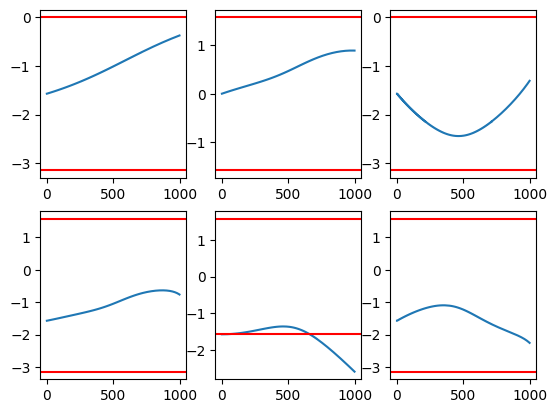

In [24]:
q_min = -np.pi * np.array( [1.0, 0.5, 1.0, 1.0, 0.5, 1.0] )
q_max = np.pi/2 * np.array( [0.0, 1.0, 0.0, 1.0, 1.0, 1.0] )

fig, axs = plt.subplots(2, 3)
axs = axs.reshape( -1 )

for i in range( 6 ):
    axs[i].axhline( y=q_max[i], color="r" )
    axs[i].plot( RobotTutorials.list_q_dk.T[i][:1000] )
    axs[i].axhline( y=q_min[i], color="r" )


Comment on the values taken by the joint variables.

---

With a correct version of $ComputeIKMlimits$, the IKM should never force impossible constraints anymore, so the joint variables should stay inside the limits without creating spikes. 

---

# Robotics - Tutorial 2 : Dynamics and control

## Introduction

We propose to study the dynamic modeling and control of the previous robot manipulator developed by the *Interactive Robotics Laboratory* of the *CEA List*. Its geometric and kinematic models were studied in Tutorial 1.
This is a continuation of Tutorial 1. Solutions of questions from tutorial 1 are sometimes required for some of the questions of the present tutorial.

The numerical values of the robot parameters, required for the completion of this tutorial, are specified in the table below.

$$
\begin{aligned}
& \text {Table. Numerical values of some robot parameters.}\\
&\begin{array}{cccc}
\hline
		\text{Parameters} &	\text{Numerical values} &	\text{Type of parameter} \\ 
		\hline
				x_{G_1}, y_{G_1}, z_{G_1} & 0m, 0m, -0.25m & \text{Coordinates of G_1 given in frame } \mathcal{R}_1 \\
		x_{G_2}, y_{G_2}, z_{G_2} & 0.35m, 0m, 0m & \text{Coordinates of G_2 given in frame } \mathcal{R}_2 \\
		x_{G_3}, y_{G_3}, z_{G_3} & 0m, -0.1m, 0m & \text{Coordinates of G_3 given in frame } \mathcal{R}_3 \\
		x_{G_4}, y_{G_4}, z_{G_4} & 0m, 0m, 0m & \text{Coordinates of G_4 given in frame } \mathcal{R}_4 \\
		x_{G_5}, y_{G_5}, z_{G_5} & 0m, 0m, 0m & \text{Coordinates of G_5 given in frame } \mathcal{R}_5 \\
		x_{G_6}, y_{G_6}, z_{G_6} & 0m, 0m, 0m & \text{Coordinates of G_6 given in frame } \mathcal{R}_6 \\
		m_1 & 15.0kg & \text{Mass of the body 1}\\
		m_2 & 10.0kg & \text{Mass of the body 2}\\
		m_3 & 1.0kg & \text{Mass of the body 3}\\
		m_4 & 7.0kg & \text{Mass of the body 4}\\
		m_5 & 1.0kg & \text{Mass of the body 5}\\
		m_6 & 0.5kg & \text{Mass of the body 6}\\
		I_1 & \begin{bmatrix} 0.80 & 0 & 0.05 \\ 0 & 0.80 & 0 \\ 0.05 & 0 & 0.10 \end{bmatrix}_{\mathcal{R}_{O_1}} kg.m^2 & \text{Inertial tensor of the body 1}\\
		I_2 & \begin{bmatrix} 0.10 & 0 & 0.10 \\ 0 & 1.50 & 0 \\ 0.10 & 0 & 1.50 \end{bmatrix}_{\mathcal{R}_{O_2}} kg.m^2 & \text{Inertial tensor of the body 2}\\
		I_3 & \begin{bmatrix} 0.05 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.05 \end{bmatrix}_{\mathcal{R}_{O_3}} kg.m^2 & \text{Inertial tensor of the body 3}\\
		I_4 & \begin{bmatrix} 0.50 & 0 & 0 \\ 0 & 0.50 & 0 \\ 0 & 0 & 0.05 \end{bmatrix}_{\mathcal{R}_{O_4}} kg.m^2 & \text{Inertial tensor of the body 4}\\
		I_5 & \begin{bmatrix} 0.01 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.01 \end{bmatrix}_{\mathcal{R}_{O_5}} kg.m^2 & \text{Inertial tensor of the body 5}\\
		I_6 & \begin{bmatrix} 0.01 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.01 \end{bmatrix}_{\mathcal{R}_{O_6}} kg.m^2 & \text{Inertial tensor of the body 6}\\
		J_{m_i} (i=1,\ldots,6) &	10\times10^{-6} kg.m^2 & \text{Moment of inertia of the actuator rotor} 	\\
		r_{red_i} (i=1,\ldots,3) &	100 & \text{Reduction ratio}	\\
		r_{red_i} (i=4,\ldots,6) &	70 & \text{Reduction ratio}	\\	
		F_{v_1}, \ldots, F_{v_6} &	10 N.m.rad^{-1}.s & \text{Joint viscous frictions} 	\\
		\tau_{max_i} (i=1,\ldots,6) &	5 N.m & \text{Maximal motor torques} 	\\
\hline
\end{array}
\end{aligned}
$$

The use of *Python* programming langage is required to perform this tutorial.

In the following, you will still progressively update the previous *Dictionnary* in *Python* containing the robot parameters, named __robotParameters__.

Please add the following items to the *Dicitionnary* as follows.

In [25]:
# Adding the coordinates of all centers of mass as a list of 3 coordinates
x_G1 = 0 ; y_G1 = 0 ; z_G1 =-0.25
x_G2 = 0.35 ; y_G2 = 0 ; z_G2 = 0
x_G3 = 0 ; y_G3 = -0.1 ; z_G3 = 0
x_G4 = 0 ; y_G4 = 0 ; z_G4 = 0
x_G5 = 0 ; y_G5 = 0 ; z_G5 = 0
x_G6 = 0 ; y_G6 = 0 ; z_G6 = 0

robotParameters['coordCentersMass'] = [np.array( [x_G1, y_G1, z_G1] ),
                                       np.array( [x_G2, y_G2, z_G2] ),
                                       np.array( [x_G3, y_G3, z_G3] ),
                                       np.array( [x_G4, y_G4, z_G4] ),
                                       np.array( [x_G5, y_G5, z_G5] ),
                                       np.array( [x_G6, y_G6, z_G6] )]

RobotTutorials = RobotModel( **robotParameters )


Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]
Attribute (list - float): self.toolDHM =  [0, 0, 0, 0.1]
Attribute (list - array of float): self.coordCentersMass =  [array([ 0.  ,  0.  , -0.25]), array([0.35, 0.  , 0.  ]), array([ 0. , -0.1,  0. ]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]


The matrix form of the inverse dynamic model for rigid robot manipulator is recalled below:
\begin{align*}
				A\left(q\right)\ddot q + C\left(q, \dot q\right)\dot q + G\left(q \right) + \Gamma_f\left(\dot q\right) = \Gamma
\end{align*}
with
\begin{align*}
 & A\left(q\right) \in \mathbb{R}^{6 \times 6} \text{ : inertia matrix, symmetric and positive definite}; \\
 & C\left(q, \dot q\right)\dot q \in \mathbb{R}^{6} \text{ : vector of joint torques due to the Coriolis and centrifugal forces};\\
 & G\left(q \right)\in \mathbb{R}^{6} \text{ : vector of joint torques due to gravity}; \\
 & \Gamma_f\left( \dot q\right)=\begin{bmatrix} \tau_{f_1} & \ldots & \tau_{f_6} \end{bmatrix} ^t\in \mathbb{R}^{6} \text{ : vector of joint friction torques}.\\
\end{align*}

The vectors of joint positions, velocities and accelerations are denoted respectively $q = \left[ q_1, \ldots, q_6 \right]^t$, $\dot q = \left[\dot{q}_1, \ldots, \dot{q}_6 \right]^t$, $\ddot q = \left[ \ddot{q}_1, \ldots,\ddot{q}_6 \right]^t$, and the vector of the joint torques is denoted $\Gamma  = \left[ \tau _1, \ldots,\tau_6 \right]^t$. The frames $\mathcal{R}_i$ attached to the links of the robot have been defined in Tutorial 1, __Q1__.

__Q11.__ The objective of this question is to determine the velocity ${}{}^0V_{G_i}$ of the center of mass $G_i$ and the rotation speed ${}{}^0\omega_i$ of all the rigid bodies $\mathcal{C}_i$ in the frame $\mathcal{R}_0$.

Write a function $ComputeJacGi(\text{self}, q)$ which returns the Jacobian matrices ${}{}^0J_{v_{G_i}}$ and ${}^0J_{\omega_i}$ defined as follows:
\begin{align*}
		{}^0V_{G_i} ={}^0J_{v_{G_i}} \left(q\right) \dot{q}   \hspace{0.5cm} \text{and} \hspace{0.5cm} {}^0\omega_{i} = {}^0J_{\omega_i}\left(q\right)\dot{q}.
\end{align*}

To answer this question, are useful: the functions developed in question __Q3__ and the function $ComputeJac(\text{self},q)$ developed in question __Q5__, providing the Jacobian ${}^0J_{O_E}$ which is used in the computation of the velocity ${}^0\mathcal{V}_{0,E}$ of the end-effector $O_E$.

In [26]:
def PreProd( u ):
    """
    Returns the prepdroduct matrix of u, such that u ^ v = PreProd( u ) @ v for all v
    """
    
    return np.array( [[0,     -u[2], u[1] ],
                      [u[2],  0,     -u[0]],
                      [-u[1], u[0],  0    ]] )


In [27]:
def ComputeJacGi( self, q_cur ):
    """ 
    Computation of the list of the Jacobian matrices mapping the joint velocities to the velocities of the centers of mass Gi for all the rigid bodies Ci in the frame R0 for a joint configuration "q_cur"
    
    Inputs:
        - List of the successive resulting homogeneous transform matrices "self.list_g_0i"
        - Direct Geometric Model through homogeneous matrix "self.g_0E"
        - List "self.coordCentersMass" of the coordinates of the centers of mass of all the bodies
        - Number of joints "self.numberJoints"
        - Current configuration "q_cur"
    
    Outputs: 
        - List "self.list_oJGi" of all the full Jacobian matrices 0_JGi in R_0 as a np.array
        - List "self.list_oJ_VGi" of all the submatrices of Jacobian matrices 0_JGi in R_0 related to the translational velocities as a np.array
        - List "self.list_oJ_wGi" of all the submatrices of Jacobian matrices 0_JGi in R_0 related to the angular velocities as a np.array
    
    """
    
    self.ComputeJac( q_cur ) # ComputeJac also updates the model

    self.list_oJGi, self.list_oJ_VGi, self.list_oJ_wGi = [], [], []
    
    for i in range( self.numberJoints ):
        g_0i = self.list_g_0i[i]
        O_OEOi = -self.g_0E[0:3, 3] + g_0i[0:3, 3] # = O_OEO0 + O_O0Oi + = -O_O0OE + O_O0Oi
        O_OiGi = g_0i[0:3, 0:3] @ self.coordCentersMass[i] # = R_0i * i_OiGi
        O_OEGi = O_OEOi + O_OiGi
        
        preprod = PreProd( O_OEGi )
        
        M = np.block ( [[np.eye( 3 ),          -preprod    ],
                        [np.zeros( ( 3, 3 ) ), np.eye( 3 ) ]] )
        oJ = np.concatenate( ( self.oJ[:, :i + 1], np.zeros( ( 6, self.numberJoints - i - 1 ) ) ), axis = 1 )
        
        self.list_oJGi.append( M @ oJ )
        self.list_oJ_VGi.append( self.list_oJGi[-1][0:3, :] )
        self.list_oJ_wGi.append( self.list_oJGi[-1][3:6, :] )
        
    return self.list_oJGi, self.list_oJ_VGi, self.list_oJ_wGi

RobotModel.ComputeJacGi = ComputeJacGi

Evaluate the Jacobian matrices ${}^0J_{v_{G_6}} \left(q\right)$ and ${}^0J_{\omega_6}\left(q\right)$ for $q = \left[\pi/4, -\pi/8, -\pi/3, 0, -\pi/2, -\pi/7  \right]^t$.


In [28]:
q = np.pi * np.array( [1/4, -1/8,-1/3, 0, -1/2, -1/7] )

RobotTutorials.ComputeJacGi( q )
print( approx( RobotTutorials.list_oJGi[-1] ) )
print( approx( RobotTutorials.list_oJ_VGi[-1] ) )
print( approx( RobotTutorials.list_oJ_wGi[-1] ) )


[[-0.476  0.33   0.14  -0.     0.     0.   ]
 [ 0.476  0.33   0.14   0.     0.    -0.   ]
 [ 0.     0.673  0.026 -0.     0.     0.   ]
 [ 0.     0.707  0.707  0.092  0.707 -0.701]
 [ 0.    -0.707 -0.707  0.092 -0.707 -0.701]
 [ 1.     0.     0.    -0.991  0.    -0.131]]
[[-0.476  0.33   0.14  -0.     0.     0.   ]
 [ 0.476  0.33   0.14   0.     0.    -0.   ]
 [ 0.     0.673  0.026 -0.     0.     0.   ]]
[[ 0.     0.707  0.707  0.092  0.707 -0.701]
 [ 0.    -0.707 -0.707  0.092 -0.707 -0.701]
 [ 1.     0.     0.    -0.991  0.    -0.131]]


__Q12.__ Write a function $ComputeMatInert\left(\text{self}, q\right)$ returning the inertia matrix $A\left(q\right) \in \mathbb{R}^{6 \times 6}$ of the robot.

To this end, take into account the inertia tensors $I_i$ expressed in their frames $\mathcal{R}_{i}$ of origin $O_i$ (you will need to express the inertia tensors in the frame $\mathcal{R}_{i}$ of origin $G_i$ using the *Huygens* theorem) and the mass $m_i$ of each body $\mathcal{C}_i$.
Moreover, the actuator inertia contributions $J_{m_i}$ ($i=1,\ldots,6$) taken after the joint level will be added the diagonal of $A\left(q\right)$ (reduction ratios $r_{red_i}$ and inertia $J_{m_i}$ are provided in the table above.

Please start adding the following mass, inertia and reduction ratio items to the *Dicitionnary* as follows.

In [29]:
# Adding the inertia matrices of all links as a list of matrices
I1 = np.array( [[0.8,  0., 0.05], [0., 0.8,  0.], [0.05, 0., 0.1 ]] )
I2 = np.array( [[0.1,  0., 0.1 ], [0., 1.5,  0.], [0.1,  0., 1.5 ]] )
I3 = np.array( [[0.05, 0., 0.  ], [0., 0.01, 0.], [0.,   0., 0.05]] )
I4 = np.array( [[0.5,  0., 0.  ], [0., 0.5,  0.], [0.,   0., 0.05]] )
I5 = np.array( [[0.01, 0., 0.  ], [0., 0.01, 0.], [0.,   0., 0.01]] )
I6 = np.array( [[0.01, 0., 0.  ], [0., 0.01, 0.], [0.,   0., 0.01]] )
robotParameters['InertiaLinks'] = [I1, I2, I3, I4, I5, I6]
# Adding the mass property of all links as a list of scalar
m1 = 15. ; m2 = 10. ; m3 = 1. ; m4 = 7. ; m5 = 1. ; m6 = 0.5
robotParameters['Mass'] = [m1, m2, m3, m4, m5, m6]
# Adding the moment of inertia of the actuator rotors
Jm1 = Jm2 = Jm3 = Jm4 = Jm5 = Jm6 = 1e-05
robotParameters['MotorInertia'] = [Jm1, Jm2, Jm3, Jm4, Jm5, Jm6]
# Adding the reduction ratio 
r_red1 = r_red2 = r_red3 = 100. ; r_red4 = r_red5 = r_red6 = 70.  
robotParameters['ReductionRatio'] = [r_red1, r_red2, r_red3, r_red4, r_red5, r_red6]
RobotTutorials = RobotModel( **robotParameters )


Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]
Attribute (list - float): self.toolDHM =  [0, 0, 0, 0.1]
Attribute (list - array of float): self.coordCentersMass =  [array([ 0.  ,  0.  , -0.25]), array([0.35, 0.  , 0.  ]), array([ 0. , -0.1,  0. ]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]
Attribute (list - array of float): self.inertiaLinks =  [array([[0.8 , 0.  , 0.05],
       [0.  , 0.8 , 0.  ],
       [0.05, 0.  , 0.1 ]]), array([[0.1, 0. , 0.1],
       [0. , 1.5, 0. ],
       [0.1, 0. , 1.5]]), array([[0.05, 0.  , 0. 

In [30]:
 def ComputeMatInert( self, q_cur ):
        """ 
        Computation of the inertia matrix of a robot evaluated at a joint configuration "q_cur"
                
        Inputs: 
           - List "self.inertiaLinks" of the inertia matrix of each link
           - List "self.mass" of the mass of each link
           - List "self.motorInertia" of the rotor inertia of each actuator
           - List "self.reductionRatio" of the reduction ratios of each motor-to-joint transmission
           - List "self.coordCentersMass" of the coordinates of the centers of mass of all the bodies
           - Number of joints: "self.numberJoints"
           - Current configuration "q_cur"
           - List "self.list_oJ_VGi" of all the submatrices of Jacobian matrices 0_JGi in R_0 related to the translational velocities as a np.array
           - List "self.list_oJ_wGi" of all the submatrices of Jacobian matrices 0_JGi in R_0 related to the angular velocities as a np.array
           - List of the successive homogeneous transform matrices "self.list_g_0i"
         
        Output: 
           - Matrix "self.inertia" of the robot evaluated at the joint configuration "q_cur"
           
        """
        
        self.ComputeJacGi( q_cur )
        
        A = np.zeros( ( self.numberJoints, self.numberJoints ) )
        for i in range( self.numberJoints ):
            A = A + self.mass[i] * ( self.list_oJ_wGi[i].T @ self.list_oJ_wGi[i] )
            A = A + self.list_oJ_wGi[i].T @ self.inertiaLinks[i] @ self.list_oJ_wGi[i]
            
            # we must take the contributions of the body-side actuators inertia into account
            A[i, i] = A[i, i] + self.reductionRatio[i]**2 * self.motorInertia[i]
        
        self.inertia = A
        return self.inertia

RobotModel.ComputeMatInert = ComputeMatInert


Evaluate the inertia matrix $A\left(q\right)$ for $q = \left[\pi/4, -\pi/8, -\pi/3, 0, -\pi/2, -\pi/7  \right]^t$.

In [31]:
q = np.pi * np.array( [1/4, -1/8,-1/3, 0, -1/2, -1/7] )
RobotTutorials.ComputeMatInert( q )
print( approx( RobotTutorials.inertia ) )


[[36.32   0.071  0.    -8.497  0.    -0.067]
 [ 0.071 20.95  10.05   0.     1.52  -0.   ]
 [ 0.    10.05  10.15   0.     1.52  -0.   ]
 [-8.497  0.     0.     8.627  0.     0.   ]
 [ 0.     1.52   1.52   0.     1.569 -0.   ]
 [-0.067 -0.    -0.     0.    -0.     0.559]]


__Q13.__ Using the computation of the eigenvalues of $A\left(q\right)$, write a function $ComputeBoundsInertia(\text{self}, q_{min}, q_{max})$ that returns two scalar numbers $0<\mu_1<\mu_2$ for the lower and the upper bounds of the inertia matrix, i.e.
\begin{align*}
			\mu_1 \mathbb{I} \preceq A\left(q\right) \preceq \mu_2 \mathbb{I}
\end{align*}
for joint angles comprised between limits $q_{min}$ et $q_{max}$ defined in question __Q9__.

In [32]:
def ComputeBoundsInertia( self, q_min, q_max ):
        """ 
        Computation of the upper and lower bounds of the inertia matrix of a robot using a random search
                
        Inputs: 
           - Vector of lower bound of joint variable "q_min"
           - Vector of upper bound of joint variable "q_max"
         
        Outputs: 
           - Scalar "self.mu_min" estimating the lower bound
           - Scalar "self.mu_max" estimating the upper bound
           
        """
        
        MaxIter = 1000
        
        q_test = q_min + np.random.rand() * ( q_max - q_min );
        self.ComputeMatInert( q_test )
        
        eigvals, _ = np.linalg.eig( self.inertia )
        
        self.mu_min, self.mu_max = min( eigvals ), max( eigvals )
        
        for i in range( 1000 ):
            q_test = q_min + np.random.rand() * ( q_max - q_min );
            self.ComputeMatInert( q_test )
            
            eigvals, _ = np.linalg.eig( self.inertia )
            
            if min( eigvals ) < self.mu_min:
                self.mu_min = min( eigvals )
            
            if max( eigvals ) > self.mu_max:
                self.mu_max = max( eigvals )
                
        return self.mu_min, self.mu_max

RobotModel.ComputeBoundsInertia = ComputeBoundsInertia


What are the two scalar numbers $\mu_1$ and $\mu_2$ found using your function?

In [33]:
RobotTutorials.ComputeBoundsInertia( q_min, q_max )
print( RobotTutorials.mu_min )
print( RobotTutorials.mu_max )


0.5268238975600954
38.76796803794234


__Q14.__ Write a function $ComputeGravTorque\left(\text{self}, q\right)$ returning the vector of joint torques due to the gravity $G\left(q \right)\in \mathbb{R}^{6}$. 
The analytical expression of the gradient of the potential energy $E_p\left(q\right) = g^t \left(\sum_{i=1}^6 m_i {}{}^0p_{G_i}\left(q\right)\right)$ can be used, that is:
\begin{align*}
			G\left(q \right) = -\left( {}^0J_{v_{G_1}}^t m_1 g  + \ldots + {}^0J_{v_{G_6}}^t  m_6 g \right) 
\end{align*}
where $g=\begin{bmatrix} 0 & 0 & -9.81 \end{bmatrix}^t$.

In [34]:
def ComputeGravTorque( self, q_cur ):
        """ 
        Computation of the vector of joint torques due to the gravity
                
        Inputs: 
           - Current joint positions "q_cur"
           - Number of joints "self.numberJoints"
           - Mass of each link: "self.mass"
           - List "self.list_oJ_VGi" of all the submatrices of Jacobian matrices 0_JGi in R_0 related to the translational velocities
         
        Output: 
           - Array of joint torques "self.gravityTorques"
           
        """
        
        g = np.array( [0.0, 0.0, -9.81] )
        
        self.ComputeJacGi( q_cur )
        
        self.gravityTorques = np.zeros( self.numberJoints )
        for i in range( self.numberJoints ):
            self.gravityTorques = self.gravityTorques + self.mass[i] * self.list_oJ_VGi[i].T @ g

        self.gravityTorques = -self.gravityTorques
        
        return self.gravityTorques
        
RobotModel.ComputeGravTorque = ComputeGravTorque


Evaluate the gravity joint torque $G\left(q\right)$ for $q = \left[\pi/4, -\pi/8, -\pi/3, 0, -\pi/2, -\pi/7  \right]^t$.

In [35]:
q = np.pi * np.array( [1/4, -1/8,-1/3, 0, -1/2, -1/7] )

RobotTutorials.ComputeGravTorque( q )
print( approx( RobotTutorials.gravityTorques ) )


[-0.    94.297  2.305 -0.     0.     0.   ]


__Q16.__ Propose an upper bound $g_b$ of $\left\| G\left(q\right) \right\|_1$, such that:
\begin{align*}
    \forall q \in \left[q_{min},q_{max}\right], \hspace{0.2cm} \left\| G\left(q\right) \right\|_1 \leq g_b 
\end{align*}
where $\left\| \bullet \right\|_1$ denotes the norm $1$ of a vector.

To do so, write a function $ComputeBoundsGravityTorques(\text{self}, q_{min}, q_{max})$ that returns the bound $g_b$.

In [36]:
def ComputeBoundsGravityTorques( self, q_min, q_max ):
        """ 
        Computation of the upper and lower bounds of the gravity torque of a robot using a random search
                
        Inputs: 
           - Vector of lower bound of joint variable "q_min"
           - Vector of upper bound of joint variable "q_max"
         
        Output: 
           - Scalar "self.gb" estimating the upper bound of the gravity torque vector
           
        """
        
        MaxIter = 1000
        
        q_test = q_min + np.random.rand() * ( q_max - q_min );
        self.ComputeGravTorque( q_test )
        
        self.gb = np.linalg.norm( self.gravityTorques, 1 )
        
        for i in range( 1000 ):
            q_test = q_min + np.random.rand() * ( q_max - q_min );
            self.ComputeGravTorque( q_test )
            
            norm = np.linalg.norm( self.gravityTorques, 1 )
            
            if norm > self.gb:
                self.gb = norm
                
        return self.gb
        
RobotModel.ComputeBoundsGravityTorques = ComputeBoundsGravityTorques


What is the scalar number $g_b$ found using your function?

In [37]:
RobotTutorials.ComputeBoundsGravityTorques( q_min, q_max )
print( RobotTutorials.gb )


117.32352793565867
